<a href="https://colab.research.google.com/github/eugenetwc/Medium-Notebooks/blob/master/arima_hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA for Hierarchical Time Series Forecasting

References:
- https://github.com/carlomazzaferro/scikit-hts-examples/blob/master/notebooks/M5.ipynb

## Stationarity

In [52]:
import datapane as dp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX


sns.set_theme()

# import warnings
# warnings.filterwarnings("ignore")

In [53]:
date = pd.date_range(start='2020-01-01', end='2020-09-01', freq='D')
y_stationary_1 = np.random.normal(0, 10, size=date.shape)
df_stationary_1 = pd.DataFrame({'y': y_stationary_1}, index=date)
df_stationary_1.head()

,y
2020-01-01,-15.503529
2020-01-02,9.014063
2020-01-03,13.548521
2020-01-04,-21.980245
2020-01-05,-7.696663


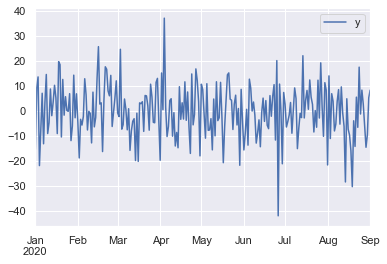

In [54]:
stationary_1_plot = df_stationary_1.plot()

In [55]:
y_stationary_2 = np.random.normal(0, 10, size=date.shape) * np.sin(2 * np.pi * np.arange(date.shape[0]))
df_stationary_2 = pd.DataFrame({'y': y_stationary_2}, index=date)
df_stationary_2.head()

,y
2020-01-01,-0.000000e+00
2020-01-02,-2.595758e-15
2020-01-03,2.038786e-15
2020-01-04,2.477355e-15
2020-01-05,7.115600e-15


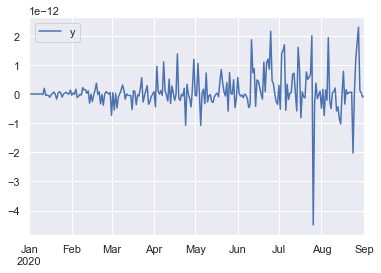

In [56]:
stationary_2_plot = df_stationary_2.plot()

# Download M5 Datset

In [57]:
# !kaggle competitions download -c m5-forecasting-accuracy

In [58]:
# !unzip m5-forecasting-accuracy.zip

# SARIMA Example

In [59]:
df = pd.read_csv('./data/sales_train_evaluation.csv', encoding='utf-8', engine='c')
train_sample = df.iloc[0][[f'd_{i}' for i in range(1, 1913+1)]].values.astype(int)
test_sample = df.iloc[0][[f'd_{i}' for i in range(1914, 1941+1)]].values.astype(int)

model = SARIMAX(train_sample, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()
preds = model_fit.forecast(test_sample.shape[0])

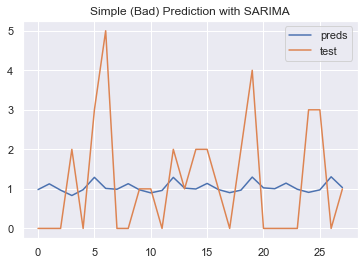

In [60]:
sarima_plot = plt.figure()
plt.title('Simple (Bad) Prediction with SARIMA')
plt.plot(preds, label='preds')
plt.plot(test_sample, label='test')
plt.legend()

In [61]:
# https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
#     print "Needs to be tested."
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


error = MASE(train_sample, test_sample, preds)
print('MASE:', error)

MASE: 2.766379692665588


In [62]:
stepwise_fit = pm.auto_arima(train_sample, start_p=0, start_q=0,
                            max_p=4, max_q=4, m=7,
                            start_P=0, start_Q=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=6076.087, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5003.616, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=5567.253, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=4813.081, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=5323.597, Time=0.33 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=4636.208, Time=0.60 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=4824.230, Time=0.36 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.30 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=4560.336, Time=0.81 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=4756.202, Time=0.42 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=2.70 s

In [63]:
preds_auto = stepwise_fit.predict(28)

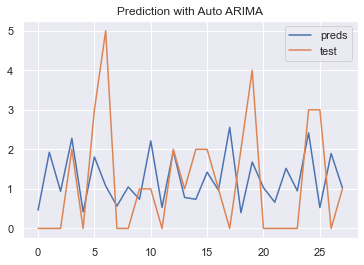

In [64]:
auto_arima_plot = plt.figure()
plt.title('Prediction with Auto ARIMA')
plt.plot(preds_auto, label='preds')
plt.plot(test_sample, label='test')
plt.legend()

In [65]:
error_auto = MASE(train_sample, test_sample, preds_auto)
print('MASE:', error)

MASE: 2.766379692665588


# HTS
## Transform data in the format required by scikit-hts

In [66]:
train = pd.read_csv('./data/sales_train_validation.csv', encoding='utf-8', engine='c')
train = train.sample(n=50, random_state=43)

# Ensures uniqueness of category, dept, and item across hierarchie
train['cat_id']  = (train['store_id'] + '_' + train['cat_id'])
train['dept_id'] = (train['store_id'] + '_' + train['dept_id'])
train['id'] = (train['store_id'] + '_' + train['id'])

In [67]:
calendar = pd.read_csv('./data/calendar.csv')

day_cols = [col for col in train.columns if col.startswith('d_')]
idx = [int(col.split('d_')[1]) for col in day_cols]

# will be useful later
train_date_id = pd.to_datetime(calendar[calendar.d.apply(lambda x: int(x.split('d_')[1])).isin(idx)].date)

In [68]:
def transpose(column, index, day_col):
    """
    Turn the row oriented time series into a column oriented one 
    """
    ts = []
    new_cols = train[column].unique()
    
    for value in new_cols:
        value_ts = train[train[column] == value]
        vertical = value_ts[day_col].sum().T
        vertical.index = index
        ts.append(vertical)
    return pd.DataFrame({k: v for k, v in zip(new_cols, ts)})

In [69]:
state_ts = transpose('state_id', train_date_id, day_cols)
store_ts = transpose('store_id', train_date_id, day_cols)
cat_ts = transpose('cat_id', train_date_id, day_cols)
dept_ts = transpose('dept_id', train_date_id, day_cols)
item_ts = transpose('id', train_date_id, day_cols)


In [70]:
df = pd.concat([state_ts, store_ts, cat_ts,dept_ts, item_ts], 1)

# Total column is the root node -- the sum of of all demand across all stores (we have data on, at least)
df['total'] = df['CA'] + df['TX'] + df['WI']

df.head()

,CA,WI,TX,CA_4,WI_2,WI_3,TX_2,CA_1,TX_3,TX_1,...,TX_3_FOODS_2_055_TX_3_validation,CA_4_HOUSEHOLD_1_524_CA_4_validation,CA_1_HOBBIES_1_328_CA_1_validation,CA_1_HOBBIES_1_295_CA_1_validation,CA_4_HOBBIES_2_095_CA_4_validation,TX_3_HOBBIES_1_213_TX_3_validation,TX_1_HOBBIES_1_089_TX_1_validation,CA_2_HOBBIES_1_177_CA_2_validation,CA_3_FOODS_1_016_CA_3_validation,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,31,12,9,0,0,6,3,10,2,4,...,0,0,2,0,0,2,0,0,3,52
2011-01-30,72,3,25,0,0,1,14,40,2,9,...,0,0,0,36,0,0,0,0,0,100
2011-01-31,59,8,11,0,0,8,9,39,0,2,...,0,0,1,36,0,0,0,0,0,78
2011-02-01,8,7,16,0,1,4,6,3,0,10,...,0,0,1,0,0,0,0,0,0,31
2011-02-02,24,5,11,0,0,5,2,9,1,8,...,0,0,0,8,0,1,0,0,0,40


In [71]:
# df.to_csv('M5_hierarchy.csv')

In [72]:
states = train.state_id.unique()
stores = train.store_id.unique()
depts = train.dept_id.unique()
cats = train.cat_id.unique()
items = train.id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(states)}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states}
store_h = {k: [v for v in cats if v.startswith(k)] for k in stores}
dept_h = {k: [v for v in depts if v.startswith(k)] for k in cats}
item_h = {k: [v for v in items if v.startswith(k)] for k in depts}

In [73]:
depts

array(['CA_4_FOODS_3', 'WI_2_HOBBIES_2', 'WI_3_FOODS_3',
       'TX_2_HOUSEHOLD_1', 'CA_1_HOUSEHOLD_2', 'TX_3_FOODS_2',
       'TX_2_HOBBIES_2', 'TX_1_FOODS_3', 'TX_3_HOUSEHOLD_1',
       'WI_1_HOUSEHOLD_1', 'WI_3_FOODS_2', 'WI_2_HOUSEHOLD_2',
       'CA_4_HOBBIES_1', 'CA_1_HOBBIES_1', 'WI_1_FOODS_1', 'TX_1_FOODS_1',
       'CA_3_FOODS_3', 'CA_1_FOODS_2', 'CA_4_FOODS_2', 'CA_4_HOBBIES_2',
       'TX_3_HOUSEHOLD_2', 'CA_1_FOODS_3', 'WI_3_HOBBIES_1',
       'CA_3_HOBBIES_1', 'WI_1_HOBBIES_1', 'CA_2_HOBBIES_2',
       'CA_2_HOUSEHOLD_1', 'CA_3_HOBBIES_2', 'CA_2_HOBBIES_1',
       'CA_2_FOODS_2', 'CA_4_HOUSEHOLD_2', 'CA_4_HOUSEHOLD_1',
       'TX_3_HOBBIES_1', 'TX_1_HOBBIES_1', 'CA_3_FOODS_1'], dtype=object)

In [74]:
# import json

hierarchy = {**total, **state_h, **store_h, **dept_h, **item_h}

# with open('hierarchy.json', 'w') as j:
#     json.dump(hierarchy, j)

### A small digression
For exemplification purposes, here's what the hierarchy tree looks like. You are unlikely to need to build it yourself, it is instead built by the library automatically


In [75]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=df)

# print(f'Root node: key: {ht.key}, children: {[k.key for k in ht.children]}')

# for child in ht.children:
#     print(f'{child.key} node\'s children: {[c.key for c in child]} ')

Let's print the tree from the California node:


In [76]:
# print(ht.children[0].key)

# print(ht.children[0])

You see the point. The hierarchy tree is recursively defined, and you can inspect any of the data of those nodes. For instance:

In [77]:
# observe the recursive structure
# print(f'Node: {ht.children[0].children[2].children[2].key}, item: ')
# ht.children[0].children[2].children[2].item

In [78]:
df = df.resample("D").sum()

## Model fitting with scikit-hts
We will be using ARIMA from the pmdarima package. scikit-hts has a wrapper for the arima model.

In [79]:
from hts import HTSRegressor

clf = HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=3)
model = clf.fit(df, hierarchy)

Fitting models: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


In [80]:
preds = model.predict(steps_ahead=28)

Fitting models: 100%|██████████| 14/14 [00:01<00:00,  7.77it/s]


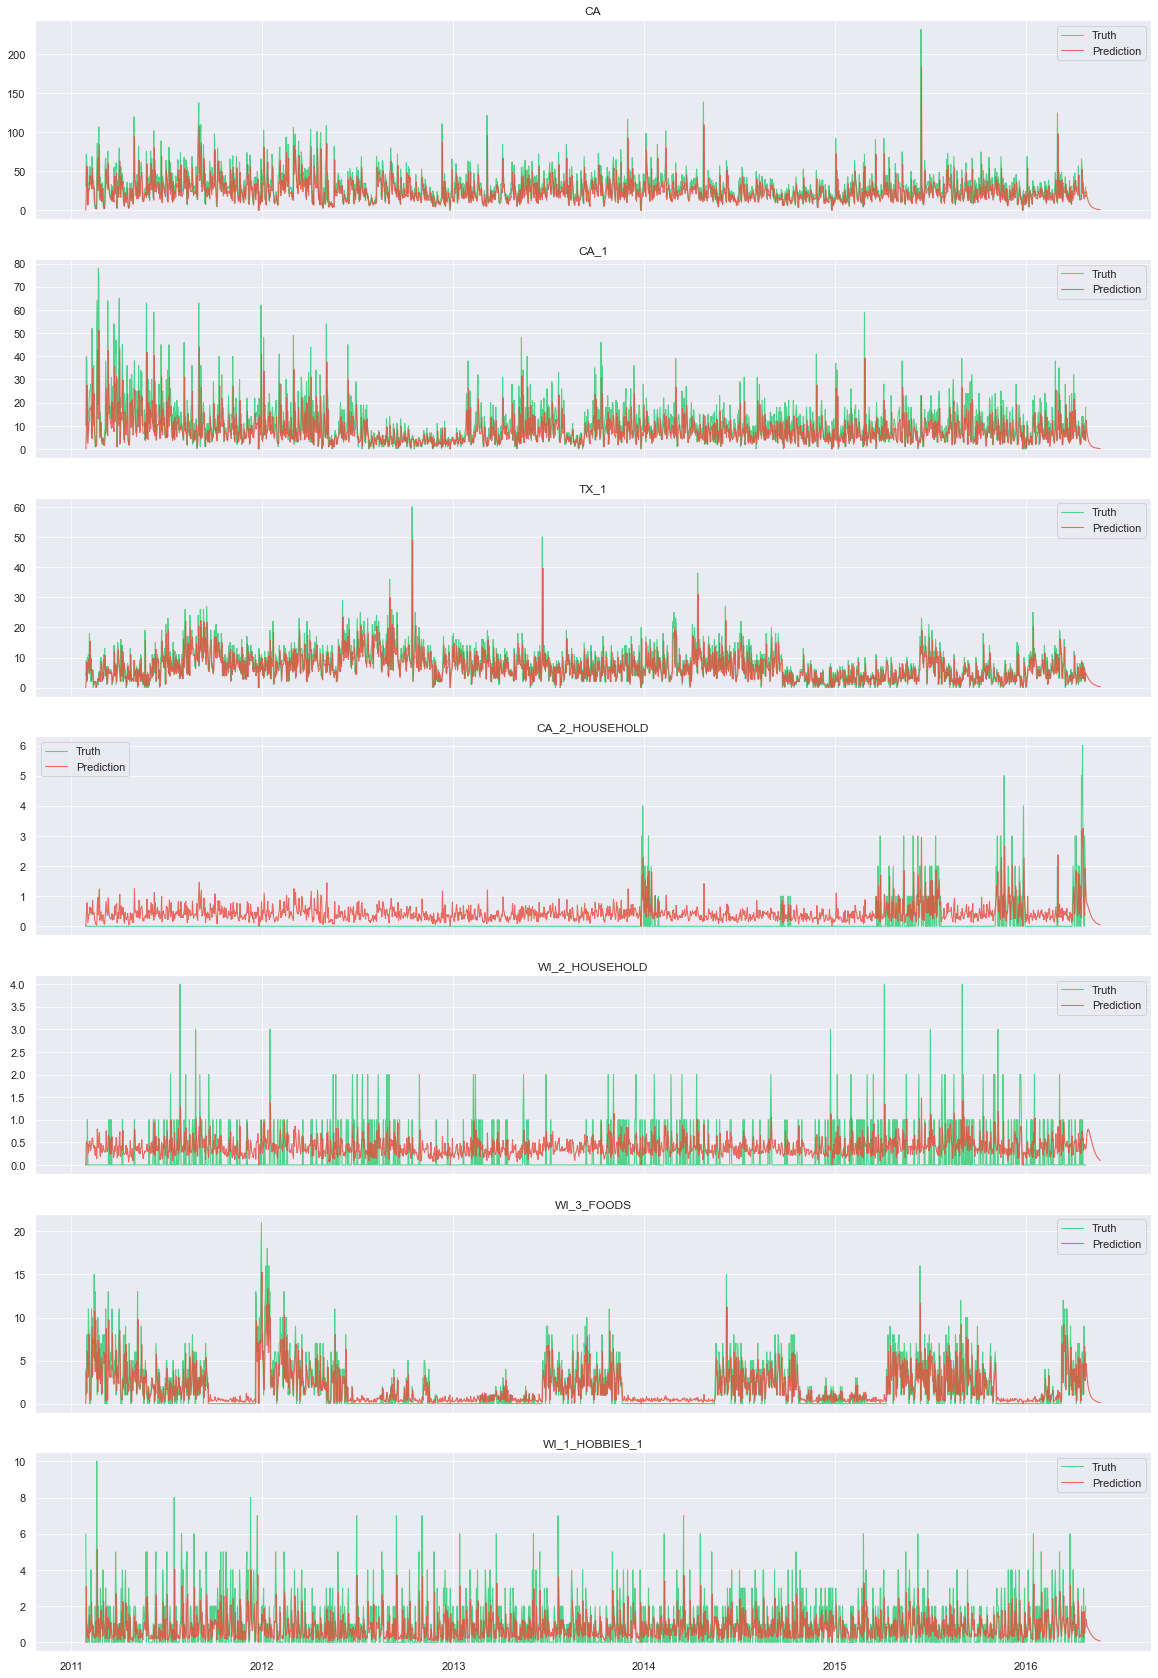

In [81]:
PLOT = ['CA', 
        'CA_1',
        'TX_1', 
        # 'CA_2_FOODS_3',
        'CA_2_HOUSEHOLD',
        'WI_2_HOUSEHOLD', 
        'WI_3_FOODS',
        # 'WI_1_FOODS_2', 
        # 'WI_1_FOODS_3',
        # 'WI_2_HOUSEHOLD_1',
        'WI_1_HOBBIES_1',
       ]

fig, axs = plt.subplots(len(PLOT), figsize=(20, 30), sharex=True)
# ax.grid(alpha=0.75)
PLOT_FROM = 0
dts = preds[PLOT_FROM:].index

for i, group in enumerate(PLOT):
    axs[i].plot(df[PLOT_FROM:][group], 
            lw=1.1, 
            color='#2ecc71', 
            alpha=0.8, 
            label='Truth')
    axs[i].plot(preds[PLOT_FROM:][group], 
            lw=1.1,
            color='#e74c3c', 
            alpha=0.8, 
            label='Prediction')
    axs[i].grid(alpha=0.75)
    axs[i].legend()
    axs[i].set_title(group)


In [95]:
report = dp.Report(
    '# ARIMA for Hierarchical Time Series Forecasting',
    'Many of you who have taken any Time Series Analysis class might have heard of ARIMA. It is one of the most widely used time series forecasting methods. Many professionals and companies, particularly the retail industry, still use it to forecast sales for the upcoming months and years for different items or stores. SARIMA is an extension of ARIMA, which it factors in the seasonality aspect of the time series.',

    '## What is SARIMA?',
    'SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. As the name suggests, it combines an autoregressive model, differencing (integration is the opposite of differencing) and a moving average model. Lets briefly explain what stationarity and differencing are, we will then move on to autoregressive and moving average models.',

    '### Stationarity',
    'A stationary time series does not depend on the time when a particular point is observed. Each point in time has a value that is not dependant on another point in time, such as white noise. The plots below are some examples of stationary time series. Other examples may include cyclic data with non-consistent periods.',
    dp.Plot(stationary_1_plot, id='stationary_1_plot'),
    dp.Plot(stationary_2_plot, id='stationary_2_plot'),

    '### Differencing',
    'Differencing is a time series transformation that attempts to eliminate time-dependent factors from the time series such as trend and seasonality. There are different orders of differencing, the equation below shows the first-order difference. It is simply the difference between the current and previous observation:',
    dp.File(file='./images/differencing_eq_1.png'),
    'After the first-order difference, if the time series is still not stationary, differencing once more will give you the second-order differencing.',
    dp.File(file='./images/differencing_eq_2.png'),
    'The order of the differencing can be defined in the d parameter of the model. Typically, the order of the differencing does not go past 2.',

    '## Autoregressive Models',
    'An autoregressive (AR) model, defined as being the regression of itself, is simply a multiple linear regression having the previous time steps as parameters to the function. It usually performs better on stationary time series data.',
    dp.File(file='./images/ar_eq_1.png'),
    'The order of the AR model, p defines the number of previous time steps that are accounted for in the current observation. For example, AR(1) accounts for time step t-1 for the current observation, AR(2) accounts for time steps t-1 and t-2.',

    '## Moving Average Models',
    'Unlike AR models, Moving Average (MA) models predict the next step based on the errors of the previous steps.',
    dp.File(file='./images/ma_eq_1.png'),
    'or can be written as,',
    dp.File(file='./images/ma_eq_2.png'),
    'The order of the MA model, q is similar to AR\'s. A larger q means that it takes into account of more number of previous time steps.'

    '### ARIMA',
    'By combining autoregression, differencing and moving average, we get an ARIMA(p, d, q) model. p, d, q are respective parameters for AR, differencing and MA.',
    dp.File(file='./images/arima_eq_1.png'),
    'y′t is the differenced series. It needs to be integrated (opposite of differencing) to get the actual series.',

    '### SARIMA',
    'Many practical time series have some aspects of seasonality in them. For example, there might be an underlying pattern for the sales every year in each quarter. SARIMA is able to capture the seasonality by including more parameter.',
    dp.File(file='./images/sarima_eq_1.png'),
    'The uppercase terms are seasonal terms corresponding to the lowercase ones, and finally m is the period. For daily data, m will be 7 to indicate there will be some repeating pattern every week.'

    '## Dataset'
    'In this article, we will be exploring the dataset from one of the largest forecasting competition in Kaggle, the M5 competition. The dataset includes the unit sales of 3,049 products sold in Walmart in the USA. It is organised in the form of grouped time series. The hierarchy of the time series is shown in the picture below. In total, including all levels of the hierarchy, the dataset contains 42,840 time series. More details of the dataset can be found here.',
    dp.File(file='./images/dataset_1.png'),
    'https://www.kaggle.com/c/m5-forecasting-accuracy',
    'To make things simple, I will only be using the date and sales values. I will not use the rest of the features such as sell prices, events etc.',
    'There are many ways to solve hierarchical time series problems, namely single level approaches such as bottom-up, top-down, and forecast reconciliation methods such as ordinary least squares (OLS) reconciliation. Typically, OLS reconciliation will have the best performance because it uses information of each hierarchy rather than a single level of aggregation. More details on different approaches can be found here.',

    '## SARIMA in Python',
    'Let\'s do a sample plot with the parameters (p=1, d=1, q=1):',
    '''
    import pandas as pd
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    df = pd.read_csv('sales_train_evaluation.csv', encoding='utf-8', engine='c')
    train = df.iloc[0][[f'd_{i}' for i in range(1, 1913+1)]].values.astype(int)
    test = df.iloc[0][[f'd_{i}' for i in range(1914, 1941+1)]].values.astype(int)

    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit()
    preds = model_fit.forecast(test.shape[0])
    ''',
    dp.Plot(sarima_plot, id='sarima_plot'),
    '''
    Mean Absolute Scaled Error: 2.766379692665588
    ''',
    'You can see that the predictions made by the model is not very good. SARIMA requires an extensive knowledge such as Box-Jenkins Methodology to be able to tune the parameters to provide a good model.',
    'We can also use Machine Learning methods for hyperparameter tuning of p, d and q. We will now explore Grid Search to find the best parameters for the all the time series.',
    'However, suppose you have many time-series which have a hierarchical structure, such as the M5 dataset, it is reasonable to use the techniques discussed in the Hierarchical Time Series section to perform forecasting on higher hierarchies.',

    '## Auto ARIMA in Python',
    'There is also a Python framework, pmdarima(docs) which allows for parameter search for both ARIMA and SARIMAX. The framework includes the function auto_arima, which takes inspiration from forecast::auto.arima from the R forecasting framework. The function does a parameter search across multiple values of p, q (and P and Q for SARIMA) and selects the best model the minimizes the information criterion, typically the AIC.',
    'Below is an example of how auto_arima is used:',
    '''
    import pmdarima as pm

    stepwise_fit = pm.auto_arima(train_sample, start_p=0, start_q=0,
                                max_p=4, max_q=4, m=7,
                                start_P=0, start_Q=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

    preds_auto = stepwise_fit.predict(28)
    ''',
    'Output:',
    '''
    Performing stepwise search to minimize aic
    ARIMA(0,1,0)(0,1,0)[7]             : AIC=6076.087, Time=0.07 sec
    ARIMA(1,1,0)(1,1,0)[7]             : AIC=5003.616, Time=0.22 sec
    ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.89 sec
    ARIMA(1,1,0)(0,1,0)[7]             : AIC=5567.253, Time=0.08 sec
    ARIMA(1,1,0)(2,1,0)[7]             : AIC=4813.081, Time=0.50 sec
    ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.69 sec
    ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.92 sec
    ARIMA(0,1,0)(2,1,0)[7]             : AIC=5323.597, Time=0.35 sec
    ARIMA(2,1,0)(2,1,0)[7]             : AIC=4636.208, Time=0.66 sec
    ARIMA(2,1,0)(1,1,0)[7]             : AIC=4824.230, Time=0.37 sec
    ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.22 sec
    ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.27 sec
    ARIMA(3,1,0)(2,1,0)[7]             : AIC=4560.336, Time=0.78 sec
    ARIMA(3,1,0)(1,1,0)[7]             : AIC=4756.202, Time=0.44 sec
    ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=2.67 sec
    ARIMA(3,1,0)(1,1,1)[7]             : AIC=inf, Time=1.37 sec
    ARIMA(4,1,0)(2,1,0)[7]             : AIC=4432.037, Time=0.97 sec
    ARIMA(4,1,0)(1,1,0)[7]             : AIC=4621.662, Time=0.70 sec
    ARIMA(4,1,0)(2,1,1)[7]             : AIC=inf, Time=4.06 sec
    ARIMA(4,1,0)(1,1,1)[7]             : AIC=inf, Time=2.18 sec
    ARIMA(4,1,1)(2,1,0)[7]             : AIC=inf, Time=7.38 sec
    ARIMA(3,1,1)(2,1,0)[7]             : AIC=inf, Time=5.96 sec
    ARIMA(4,1,0)(2,1,0)[7] intercept   : AIC=4434.037, Time=2.54 sec

    Best model:  ARIMA(4,1,0)(2,1,0)[7]          
    Total fit time: 38.291 seconds
    ''',
    dp.Plot(auto_arima_plot, id='auto_arima_plot'),

    '## SARIMA with Hierarchical Forecasting',
    'The Python framework scikit-hts allows us to easily perform hierarchical time series modelling. The framework uses either Prophet, Auto-ARIMA, SARIMAX or Holt-Winters as the underlying model for HTS modelling. It also includes many of HTS methods discussed above such as Bottom-Up, Top-Down, OLS etc.',
    'The plots below show the predictions for each hierarchy with the M5 dataset using scikit-hts. The model used is SARIMA with OLS reconciliation.',
    dp.Plot(fig, id='hierarchical_plots'),

    '## Conclusion',
    'Congratulations! You have reached the end of this article. I hope this article will give you a brief understanding of SARIMA and Hierarchical Time Series. These tools have been around for a long time but are still used in industries due to their simplicity and performance.',
    'There have also been many Machine Learning and Deep Learning methods emerging in the forecasting field. These methods are used when large abundance of data is available. Some notable methods/frameworks include CNN-QR, DeepAR+ and Prophet.',

    '## References',
    dp.Text(
'''
https://medium.com/r/?url=https%3A%2F%2Fotexts.com%2Ffpp3%2F\n
https://medium.com/r/?url=https%3A%2F%2Fotexts.com%2Ffpp3%2F
'''),

)

# report.preview()

In [96]:
report.publish(name='ARIMA for Hierarchical Time Series Forecasting', open=True, source_url='https://github.com/eugeneteoh/Medium-Notebooks/tree/master/arima_hierarchical')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/eugene/reports/arima-for-hierarchical-time-series-forecasting/
